In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from datasets import load_dataset
from seqeval.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score
from torch.nn.utils.rnn import pad_sequence
from torch.optim import AdamW
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer

/Users/devambani/Projects/nlp/nlp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the CoNLL-2003 dataset
dataset = load_dataset("conll2003")
label_list = dataset["train"].features["ner_tags"].feature.names
num_labels = len(label_list)

In [3]:
# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-base", add_prefix_space=True)

In [4]:
def tokenize_and_align_labels(batch):
    tokenized_inputs = tokenizer(batch["tokens"], truncation=True, is_split_into_words=True)
    labels = []
    for i, label in enumerate(batch["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        aligned_labels = [-100 if word_id is None else label[word_id] for word_id in word_ids]
        labels.append(aligned_labels)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True)

Map: 100%|██████████| 3250/3250 [00:00<00:00, 11655.47 examples/s]


In [5]:
def collate_fn(batch):
    input_ids = [torch.tensor(x["input_ids"]) for x in batch]
    attention_mask = [torch.tensor(x["attention_mask"]) for x in batch]
    labels = [torch.tensor(x["labels"]) for x in batch]

    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask_padded = pad_sequence(attention_mask, batch_first=True, padding_value=0)
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=-100)

    return {
        "input_ids": input_ids_padded,
        "attention_mask": attention_mask_padded,
        "labels": labels_padded,
    }

train_loader = DataLoader(tokenized_datasets["train"], batch_size=64, collate_fn=collate_fn)
val_loader = DataLoader(tokenized_datasets["validation"], batch_size=64, collate_fn=collate_fn)

In [6]:
class RoBERTaForNER(nn.Module):
    def __init__(self, pretrained_model_name, num_labels, dropout_rate=0.3):
        super(RoBERTaForNER, self).__init__()
        self.roberta = AutoModel.from_pretrained(pretrained_model_name, output_hidden_states=True)
        self.num_hidden_layers = self.roberta.config.num_hidden_layers + 1
        self.layer_weights = nn.Parameter(torch.ones(self.num_hidden_layers))
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(self.roberta.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = torch.stack(outputs.hidden_states, dim=0)
        weighted_hidden_states = torch.sum(self.layer_weights[:, None, None, None] * hidden_states, dim=0)
        sequence_output = self.dropout(weighted_hidden_states)
        logits = self.classifier(sequence_output)

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            active_loss = attention_mask.view(-1) == 1
            active_logits = logits.view(-1, logits.size(-1))[active_loss]
            active_labels = labels.view(-1)[active_loss]
            loss = loss_fn(active_logits, active_labels)

        return {"loss": loss, "logits": logits}

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 220/220 [12:09<00:00,  3.32s/it]

Epoch 1 Loss: 0.4667081406501397


Epoch 3: 100%|██████████| 220/220 [08:41<00:00,  2.37s/it]


Epoch 3 Loss: 0.0768, Accuracy: 0.3523


Epoch 4: 100%|██████████| 220/220 [08:41<00:00,  2.37s/it]


Epoch 4 Loss: 0.0454, Accuracy: 0.3550


Epoch 5: 100%|██████████| 220/220 [08:42<00:00,  2.37s/it]


Epoch 5 Loss: 0.0329, Accuracy: 0.3561


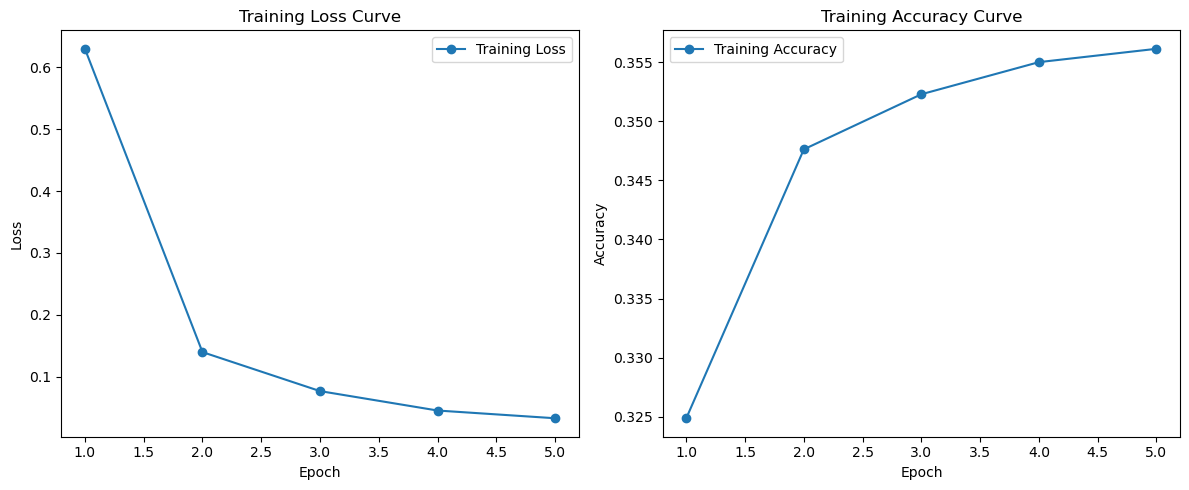

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RoBERTaForNER(pretrained_model_name="roberta-base", num_labels=num_labels, dropout_rate=0.3).to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Initialize lists to store metrics
training_losses = []
training_accuracies = []

# Training Loop
epochs = 1
for epoch in range(epochs):
    model.train()
    total_loss = 0
    all_predictions = []
    all_labels = []
    
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs["loss"]
        logits = outputs["logits"]
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Convert logits to predictions
        predictions = torch.argmax(logits, dim=-1).view(-1).cpu().numpy()
        true_labels = labels.view(-1).cpu().numpy()

        # Append for accuracy calculation
        all_predictions.extend(predictions)
        all_labels.extend(true_labels)
    
    # Calculate average loss and accuracy for the epoch
    avg_loss = total_loss / len(train_loader)
    training_losses.append(avg_loss)

    accuracy = accuracy_score(all_labels, all_predictions)
    training_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1} Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

# Plot training curves
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), training_losses, marker='o', label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), training_accuracies, marker='o', label="Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()


In [9]:
# model.eval()
# predictions, true_labels = [], []
# with torch.no_grad():
#     for batch in tqdm(val_loader, desc="Evaluating"):
#         input_ids = batch["input_ids"].to(device)
#         attention_mask = batch["attention_mask"].to(device)
#         labels = batch["labels"].to(device)

#         outputs = model(input_ids=input_ids, attention_mask=attention_mask)
#         logits = outputs["logits"]
#         preds = torch.argmax(logits, dim=-1)

#         for pred, label in zip(preds.cpu().numpy(), labels.cpu().numpy()):
#             predictions.append([label_list[p] for p, l in zip(pred, label) if l != -100])
#             true_labels.append([label_list[l] for p, l in zip(pred, label) if l != -100])

# # Compute classification report
# print(classification_report(true_labels, predictions))

Evaluating: 100%|██████████| 51/51 [00:33<00:00,  1.51it/s]


              precision    recall  f1-score   support

         LOC       0.88      0.95      0.91      3323
        MISC       0.71      0.74      0.72      1355
         ORG       0.86      0.88      0.87      2672
         PER       0.96      0.95      0.96      3238

   micro avg       0.88      0.91      0.89     10588
   macro avg       0.85      0.88      0.87     10588
weighted avg       0.88      0.91      0.89     10588



In [ ]:
# from sklearn.metrics import classification_report

# # Put the model in evaluation mode
# model.eval()

# # Initialize lists for predictions and true labels
# test_predictions, test_true_labels = [], []

# with torch.no_grad():
#     for batch in tqdm(test_loader, desc="Testing"):
#         input_ids = batch["input_ids"].to(device)
#         attention_mask = batch["attention_mask"].to(device)
#         labels = batch["labels"].to(device)

#         # Forward pass
#         outputs = model(input_ids=input_ids, attention_mask=attention_mask)
#         logits = outputs["logits"]
#         preds = torch.argmax(logits, dim=-1)

#         # Collect predictions and true labels, ignoring padding tokens (-100)
#         for pred, label in zip(preds.cpu().numpy(), labels.cpu().numpy()):
#             test_predictions.append([label_list[p] for p, l in zip(pred, label) if l != -100])
#             test_true_labels.append([label_list[l] for p, l in zip(pred, label) if l != -100])

# # Flatten the lists for evaluation
# flat_test_predictions = [p for preds in test_predictions for p in preds]
# flat_test_true_labels = [l for labels in test_true_labels for l in labels]

# # Generate and print the classification report
# print(classification_report(flat_test_true_labels, flat_test_predictions))


In [22]:
test_loader = DataLoader(tokenized_datasets["test"], batch_size=64, collate_fn=collate_fn)

In [23]:
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)
import numpy as np

def evaluate_model(model, data_loader, label_list, device, dataset_name="Evaluation"):
    """
    Evaluate the model on a given data loader and print detailed metrics.

    Args:
    - model: The trained model to evaluate.
    - data_loader: DataLoader for the evaluation dataset (e.g., validation or test set).
    - label_list: List of labels used in the dataset.
    - device: Device to run the evaluation (e.g., 'cuda' or 'cpu').
    - dataset_name: Name of the dataset (e.g., 'Validation' or 'Test') for reporting.
    """
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc=f"Evaluating {dataset_name}"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs["logits"]
            preds = torch.argmax(logits, dim=-1)

            # Collect predictions and true labels, ignoring padding tokens (-100)
            for pred, label in zip(preds.cpu().numpy(), labels.cpu().numpy()):
                predictions.append([label_list[p] for p, l in zip(pred, label) if l != -100])
                true_labels.append([label_list[l] for p, l in zip(pred, label) if l != -100])

    # Flatten the lists for evaluation
    flat_predictions = [p for preds in predictions for p in preds]
    flat_true_labels = [l for labels in true_labels for l in labels]

    # Calculate metrics
    accuracy = accuracy_score(flat_true_labels, flat_predictions)
    precision = precision_score(flat_true_labels, flat_predictions, average="weighted")
    recall = recall_score(flat_true_labels, flat_predictions, average="weighted")
    f1 = f1_score(flat_true_labels, flat_predictions, average="weighted")
    conf_matrix = confusion_matrix(flat_true_labels, flat_predictions, labels=label_list)

    # Print the metrics
    print(f"\n{dataset_name} Metrics:")
    print("Classification Report:")
    print(classification_report(flat_true_labels, flat_predictions))

    print("\nAdditional Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Weighted): {precision:.4f}")
    print(f"Recall (Weighted): {recall:.4f}")
    print(f"F1 Score (Weighted): {f1:.4f}")

    print("\nConfusion Matrix:")
    print(conf_matrix)


# Example usage
print("Starting Evaluation and Testing...\n")

# Evaluate on validation set
evaluate_model(model, val_loader, label_list, device, dataset_name="Validation")

# Evaluate on test set
evaluate_model(model, test_loader, label_list, device, dataset_name="Test")


Starting Evaluation and Testing...



Evaluating Validation: 100%|██████████| 51/51 [00:32<00:00,  1.57it/s]



Validation Metrics:
Classification Report:
              precision    recall  f1-score   support

       B-LOC       0.97      0.94      0.96      3323
      B-MISC       0.89      0.89      0.89      1355
       B-ORG       0.91      0.96      0.93      2672
       B-PER       0.98      0.98      0.98      3238
       I-LOC       0.96      0.89      0.92       315
      I-MISC       0.88      0.78      0.83       502
       I-ORG       0.88      0.97      0.92       988
       I-PER       0.99      0.99      0.99      2823
           O       1.00      1.00      1.00     49966

    accuracy                           0.99     65182
   macro avg       0.94      0.93      0.94     65182
weighted avg       0.99      0.99      0.99     65182


Additional Metrics:
Accuracy: 0.9854
Precision (Weighted): 0.9856
Recall (Weighted): 0.9854
F1 Score (Weighted): 0.9854

Confusion Matrix:
[[49739    14     8    40    52    23     0    59    31]
 [    9  3159     9    43     0    11     0     7     

Evaluating Test: 100%|██████████| 54/54 [00:31<00:00,  1.74it/s]



Test Metrics:
Classification Report:
              precision    recall  f1-score   support

       B-LOC       0.94      0.91      0.92      2720
      B-MISC       0.78      0.75      0.77      1147
       B-ORG       0.88      0.95      0.91      3234
       B-PER       0.96      0.95      0.96      2866
       I-LOC       0.90      0.86      0.88       342
      I-MISC       0.50      0.68      0.58       291
       I-ORG       0.81      0.96      0.88      1231
       I-PER       0.98      0.99      0.99      2561
           O       1.00      0.99      0.99     45944

    accuracy                           0.97     60336
   macro avg       0.86      0.89      0.87     60336
weighted avg       0.97      0.97      0.97     60336


Additional Metrics:
Accuracy: 0.9724
Precision (Weighted): 0.9742
Recall (Weighted): 0.9724
F1 Score (Weighted): 0.9730

Confusion Matrix:
[[45333    35    15    89   125    45    14   125   163]
 [   20  2729    19    62     7    23     0     5     1]
 [ 

In [31]:
# Put the model in evaluation mode
model.eval()

# Get the first batch from the test loader
batch = next(iter(test_loader))

# Move inputs to the device
input_ids = batch["input_ids"].to(device)
attention_mask = batch["attention_mask"].to(device)
labels = batch["labels"].to(device)

# Run the model without computing gradients
with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs["logits"]

# Decode the predictions
predictions = torch.argmax(logits, dim=-1).cpu().numpy()
true_labels = labels.cpu().numpy()
tokens = batch["input_ids"].cpu().numpy()

# Example to display: adjust `example_idx` for a different sample
example_idx = 0

# Tokenized sentence
token_list = tokenizer.convert_ids_to_tokens(tokens[example_idx])

# Filter out <pad> tokens and special tokens like [CLS] and [SEP]
filtered_tokens = [
    token for token, pred in zip(token_list, predictions[example_idx])
    if token not in ["<cls>", "<sep>", "<pad>"]
]
filtered_labels = [
    label_list[pred] for token, pred in zip(token_list, predictions[example_idx])
    if token not in ["<cls>", "<sep>", "<pad>"]
]

# Reconstruct the sentence (ignoring special tokens)
sentence = tokenizer.convert_tokens_to_string(filtered_tokens)

# Print output in the desired format
print(f"Test Input Sentence:\n {sentence}")
print("\nTokenized Input:")
print(filtered_tokens)
print("\nPredicted Labels:")
print(filtered_labels)


Test Input Sentence:
 <s> SOCCER - JAPAN GET LUCKY WIN , CHINA IN SURPRISE DEFEAT .</s>

Tokenized Input:
['<s>', 'ĠSO', 'CC', 'ER', 'Ġ-', 'ĠJ', 'AP', 'AN', 'ĠGET', 'ĠL', 'UCK', 'Y', 'ĠWIN', 'Ġ,', 'ĠCH', 'INA', 'ĠIN', 'ĠSUR', 'PR', 'ISE', 'ĠDE', 'FE', 'AT', 'Ġ.', '</s>']

Predicted Labels:
['I-ORG', 'O', 'O', 'O', 'O', 'B-LOC', 'B-LOC', 'B-LOC', 'O', 'B-ORG', 'B-ORG', 'B-LOC', 'O', 'O', 'B-LOC', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-ORG']
